# Castroville Slough Treatment Wetland Bioreactor: a preliminary Python-based analysis

#### Katherine Duncan

### Introduction

#### *Background and study site introduction*

An estimated 21% of wetlands have been lost globally since 1700—with some regional hotspots in North America experiencing losses exceeding 50% (Fluet-Chouinard et al. 2023). The majority of this loss is due to agricultural and urban development (Ballut-Dajud et al. 2022; Fluet-Chouinard et al. 2023). Furthermore, agricultural runoff into waterways contributes to eutrophication that, in the worst-case-scenario, can lead to persistent anoxic or hypoxic zones (Howarth et al. 2011). Eutrophication often stems from nutrient runoff and the loss of wetlands further exacerbates the issue by contributing to increased eutrophication (Howarth et al. 2011, McCormick et al. 2009).

Water quality and wetlands in Monterey County have experienced declines similar to global trends. Historical maps and written records spanning the Elkhorn, Tembladero, and Moro Cojo Sloughs indicate significant loss of wetland habitat since the 1800s that includes tidal marshes, willow stands, and mudflats (Woolfolk 2020). However, the full extent of these losses has yet to be quantified, though local wetland habitats have predominantly been converted to agricultural or pastoral land (Woolfolk 2020). The Elkhorn Slough Reserve actively monitors water quality and eutrophication in local wetlands. In 2010, nearly all monitored sites, except one, exhibited moderate to hypereutrophic conditions (Hughes et al. 2010). However, by 2019 there was a notable improvement in water quality and eutrophication, particularly in areas associated with restoration efforts or those not subject to tidal restrictions (Hicks et al. 2019). Despite overall improvements in Elkhorn and Tembladero Sloughs, Moro Cojo Slough remained more heavily eutrophied (Hicks et al. 2019)—a discrepancy that may be attributed in part to Moro Cojo's hydrology being altered by agriculture-associated water-control structure such as pumps, drainage-channels, and levees (The Habitat Restoration Group 1996).

In [1]:
#Import cartopy and pyplot modules to create map for introduction plus later plots
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt

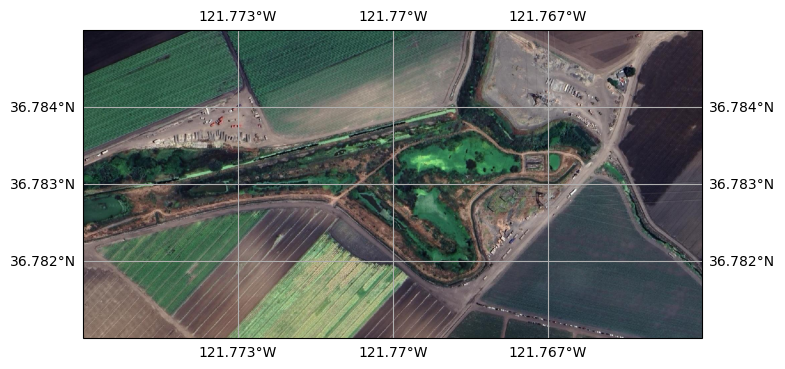

In [2]:
#Set latitudinal and longitudinal range of map
extent_wetland = [-121.775, -121.765, 36.781, 36.785]
# Request Google satellite image overlay
request = cimgt.GoogleTiles(style='satellite')
#Initialize figure and plot satellite imagery
plt.figure(figsize=[12,4])
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(extent_wetland)
ax.add_image(request, 18)
#Format gridlines and reduce number of axis ticks/labels
gl = ax.gridlines(draw_labels=True)
gl.ylocator = plt.MaxNLocator(4)
gl.xlocator = plt.MaxNLocator(4)

<b>Figure 1.</b> Overhead map of CSTW and Castroville Ditch feeding in from the Southeast.

Conservation and pollution mitigation efforts offer a promising avenue for enhancing overall water quality in Moro Cojo. The Central Coast Wetlands Group, in collaboration with landowners, is actively engaged in such endeavors by focusing on restoring wetlands along the periphery of farmland in the form of treatment wetlands. These treatment wetlands serve three purposes: mitigating the influx of excess nutrients and pollutants into waterways, providing vital habitat for native species and migratory birds, and acting as a buffer against flooding. One easement managed by CCWG, the Castroville Slough Treatment Wetland (CSTW; fig. 1), has been operational since November 2016.

Agricultural runoff is pumped from the Castroville Ditch to CSTW where excess nutrients are removed from the water as it passes through CSTW and flows out into the remaining Castroville Wetland. Monitoring efforts indicate that while CSTW successfully mitigates excess nitrogen and phosphorus from agricultural runoff, the removal capacity has shifted as the wetland has matured. Within two months of November 2016, CSTW demonstrated significant reductions in excess nutrients passing through the easement with a 50% reduction in nitrate, 60% reduction in ammonia, and an 86% reduction in phosphate (Central Coast Wetlands Group 2016). A subsequent analysis in 2017 revealed shifts in nutrient removal rates, from when water entered to when it exited there was a  99.97% reduction in nitrate, a 96.95% reduction in ammonia, and an 81.43% reduction in phosphate (Conlen et al. 2017). While treatment wetlands are an effective method for mitigating nutrient runoff, other approaches to mitigation, such as bioreactors, can offer enhanced removal rates.

To test the effectiveness of four remediation strategies, CSTW hosted a 12-channel bioreactor experiment towards the beginning of the wetland located immediately after the forebay. Water passed from the forebay through the 12 treatment channels and water parameters in the forebay and from the 12-channles discharge was monitored and recorded by an autonomous analyzer that provided near-continuous resolution when functioning. An overarching goal of this experiment was to gauge different treatments' ability to enhance nutrient removal when paired with an agricultural wetland. This experiment ran from mid-2017 to early 2021; however, data from only one channel has been analyzed (Krone et al. 2022).

#### *Experimental bioreactor background and setup*

The bioreactor experiment at CSTW ran from 06/05/ 2017 through 02/15/2021. The bioreactor was setup so that runoff from the Castroville Ditch was pumped into a forebay at the head of CSTW. This discharge then flowed through a 12-channel bioreactor which hosted three different treatments and a control with replicates spanning channels. A total of four treatments were applied over the course of the experiment: 
* Channels containing woodchips (woodchip treatment)
* Channels containing woodchips covered with plastic to conserve heat (covered woodchip treatment)
* Channels planted with _Hydrocotyle_ (_Hydrocotyle_ treatment)
* Channels planted with wetland vegetation (wetland treatment)

The experiment was divided into two phases. The first phase ran from 2017 through late-2018 with the following channels assigned as controls and treatments:
* Controls—Channels 2, 7, and 11
* Woodchip treatment—Channels 1, 5, and 9
* Covered woodchip treatment—Channels 3, 8, and 12
* _Hydrocotyle_ treatment—Channels 4, 6, and 10

The second phase running from late 2018 through 2021 covered the following treatments with assigned channels:

* Controls—Channels 4, 6, 7, and 10
* Woodchip treatment—Channels 1, 3, 5, 8, and 9
* Wetland treatment—Channels 2, 11, and 12

Water flowing from the forebay into the 12 channels using a custom monitoring system (Hydra). The Hydra was equipped thirteen lines that sampled water from the forebay and the discharge of the 12 channels. When the Hydra functioned, it could record near continuous with measurement occurring every 15 to 30 minutes. In a personal communication, Jason Adelaars indicated that Eureka Water Probe (model unknown) was most likely used for Phase 1 which ran from approximately June 2017 through September 2018 (estimated from data coverage and time gaps in CSV files). While in Phase 2, a Seabird SUNA V2 was used to measure nitrogen concentrations while other parameters such as temperature, conductivity, salinity, and dissolved oxygen were quantified with unspecified instrumentation. This phase most likely ran from November 2018 through February 2021, but may have begun as early as mid-October in 2018 based on data coverage and time gaps. However, data coverage for temperature and other parameters aside from nitrogen are not available in October 2018, making  November 2018 a more likely start of Phase 2.

Measurements for water parameters were recorded and stored as CSV files (see HydraData directory) labeled as fb for forebay and c1 through c12 for channels 1 through 12 of the bioreactor. An additional CSV labeled blank.csv was provided, but the exact purpose of its contents was not given or immediately discernable from available documentation. It most likely represents corrections to instrumentation measurements from samples used to determine background noise. 

Each of the bioreactor csv files has columns with information for multiple forms of reporting the time of the measurement and a series of data columns with no given units or explanation. Some likely units and the type of data in columns are surmisable from context and available documents:
* ‘temp’ = Temperature (degrees Celsius [°C])
* ‘cond’ = Conductivity (units uncertain)
* ‘sal’ = Salinity (practical salinity units [PSU])
* ‘nitrate’ = Nitrate (micromolar [μM])
* ‘hdo’ = Dissolved oxygen (units uncertain)
* ‘sat’ = Unknown; likely a saturation value of somesort
* ‘phv’ = Unknown; most likely related to pH or an alternative pH reading
* ‘ph’ = pH
* ‘s_nitrogen’ = Nitrate (micromolar [μM]); used during the second phase
* ‘s_nitrate’ = Nitrogen (concentration in mg/L [ppm]); used during the second phase

The overarching goal of the following figures and analyses is to begin exploring the available data and ultimately address whether there are changes in water parameters from the forebay to treatment channels and if there are significant differences across treatment type.

<b>Note: </b> The five primary information sources used to detail this section are the datafiles themselves, treatment documentation provided by CCWG, Krone et al. 2022, the Seabird SUNA V2 user manual, and personal communication with Jason Adelaars who who worked with the Hydra and formatted the data sets in SQL during his time at CCWG. PGEBioreactorChannelTreatments.xlsx is available in HyrdaData/Bioreactor_Documentation subdirectory for the unmodified file provided by CCWG that covers channel treatment assignments. A Seabird SUNA V2 user manual and Krone et al. 2022 are available in the HyrdaData/Bioreactor_Documentation/Bioreactor_AdditionalInformationSources subdirectory. 

### Data description, import, and wrangling

#### *Unpacking and parsing bioreactor channel data*

In [3]:
#Import packages and modules for data parsing, analysis, and visualization
import pandas as pd
import CSWTBioreactorFunctions as CBRF
import numpy as np
from scipy import linalg
from scipy import stats
import pingouin as pg
import seaborn as sns

The fileimport function in the CSWTBioreactorFunctions was created to read, parse, and store data from 12 CSV files containing Hydra data for the forebay and 12 treatments from the HydraData directory.

In [4]:
#Importing and parsing forebay and channel data from csv files in HydraData directory
dffb,dfclist,dfc1,dfc2,dfc3,dfc4,dfc5,dfc6,dfc7,dfc8,dfc9,dfc10,dfc11,dfc12 = CBRF.fileimport()

The data sets have three different columns for nitrogen concentrations labeled 'nitrate', 's_nitrate', and 's_nitrogen'. The data for the first round of treatments (Phase 1) primarily used the ‘nitrate’ column to record concentrations and has much fewer negative values than after treatments were transitioned (Phase 2) and the ’s_nitrate’ and ’s_nitrogen’ columns were used to record data.

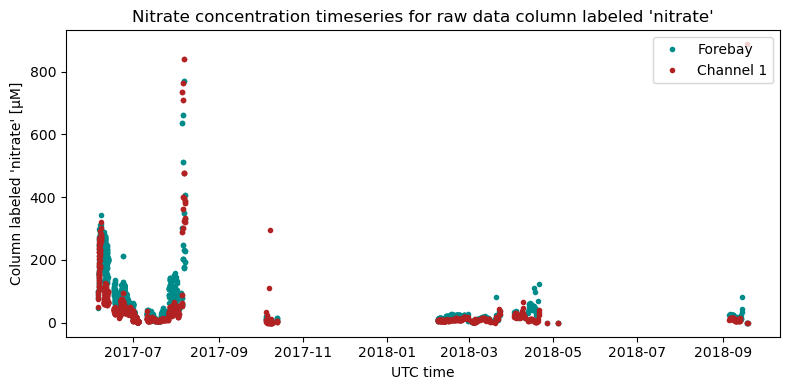

In [5]:
#Initializing figure to illustrate raw data structure in the 'nitrate' column
plt.figure(figsize=[8, 4])
plt.plot(dffb['utc_time'], dffb['nitrate'], '.', color='darkcyan', label='Forebay')
plt.plot(dfc1['utc_time'], dfc1['nitrate'], '.', color='firebrick', label='Channel 1')
plt.xlabel('UTC time')
plt.ylabel("Column labeled 'nitrate' [μM]")
plt.title("Nitrate concentration timeseries for raw data column labeled 'nitrate'")
plt.legend(loc=1)
plt.tight_layout()

<b>Figure 2.</b> Nitrate concentration plotted from raw data in the 'nitrate' column for the forebay and channel 1 (woodchip treatment).

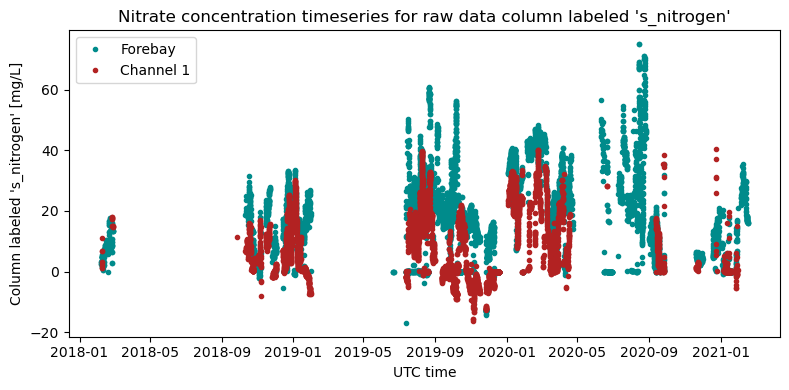

In [6]:
#Initializing figure to illustrate raw data structure in the 's_nitrate' column
plt.figure(figsize=[8, 4])
plt.plot(dffb['utc_time'], dffb['s_nitrogen'], '.', color='darkcyan', label='Forebay')
plt.plot(dfc1['utc_time'], dfc1['s_nitrogen'], '.', color='firebrick', label='Channel 1')
plt.xlabel('UTC time')
plt.ylabel("Column labeled 's_nitrogen' [mg/L]")
plt.title("Nitrate concentration timeseries for raw data column labeled 's_nitrogen'")
plt.legend(loc=2)
plt.tight_layout()

<b>Figure 3.</b> Nitrate concentration plotted from raw data in the 's_nitrate' column for the forebay and channel 1 (woodchip treatment). 

While an initial inspection suggests that Phase 1 has cleaner data due to the lack of negative values (fig. 2), it lacks coverage in comparison to Phase 2 (fig. 3). Additionally, Jason Adelaars indicated that measurements taken using the SUNA V2 in Phase 2 were more accurate than the Eureka probe used in Phase 1 and that the ‘s_nitrogen’ column for Phase 2 is more likely to provide the most accurate data. Krone et al. 2022 also identified four time periods with good data coverage for channel 5, thus those same timeframes were isolated. The following Unix time frames will be used isolate timeframes used in Krone et al. 2022:

_First period_
* 1545638400 = Dec 24 2018 0:00 UTC-800 (Pacific Standard Time)
* 1546394400 = Jan 1 2019 18:00 UTC-800 (PST)

_Second period_
* 1546596000 = Jan 4 2019 02:00 UTC-800 (PST)
* 1547107200 = Jan 10 2019 00:00 UTC-800 (PST)

_Third period_
* 1566270000 = Aug 19 2019 20:00 UTC-700 (Pacific Daylight Time)
* 1566795600 = Aug 25 2019 22:00 UTC-700 (PDT)

_Fourth period_
* 1578110400 = Jan 03 2020 20:00 UTC-800 (PST)
* 1579176000 = Jan 16 2020 04:00 UTC-800 (PST)

However, before the timeframes are isolated, treatment and channel labels will be added to each dataframe to streamline down-stream analyses and figure generation. 

In [7]:
#Adding 'channel' and 'treatment' columns for phase 2 before parsing data. Treatment column does NOT apply to phase 1
#Forebay
dffb['treatment'] = 'Untreated'
dffb['channel'] = 'Forebay'

dfc1['treatment'] = 'Untreated'
dffb['channel'] = 'Forebay'

#Controls
dfc4['treatment'] = 'Control'
dfc4['channel'] = 'Four'
dfc6['treatment'] = 'Control'
dfc6['channel'] = 'Six'
dfc7['treatment'] = 'Control'
dfc7['channel'] = 'Seven'
dfc10['treatment'] = 'Control'
dfc10['channel'] = 'Ten'

#Woodchip
dfc1['treatment'] = 'Woodchip'
dfc1['channel'] = 'One'
dfc3['treatment'] = 'Woodchip'
dfc3['channel'] = 'Three'
dfc5['treatment'] = 'Woodchip'
dfc5['channel'] = 'Five'
dfc8['treatment'] = 'Woodchip'
dfc8['channel'] = 'Eight'
dfc9['treatment'] = 'Woodchip'
dfc9['channel'] = 'Nine'

#Wetland
dfc2['treatment'] = 'Wetland'
dfc2['channel'] = 'Two'
dfc11['treatment'] = 'Wetland'
dfc11['channel'] = 'Eleven'
dfc12['treatment'] = 'Wetland'
dfc12['channel'] = 'Twelve'

The following code parses and isolates timeframes in Krone et al. 2022 across all channels and the forebay.

In [8]:
#Isolating forebay data to timeframes used in Krone et al. 2022
dffb_full, dffb_sub1, dffb_sub2, dffb_sub3, dffb_sub4 = CBRF.multiple_timewindows(dffb, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
#Naming dataframes based on treatment and channel while isolating them to Krone et al. 2022 timeframes
#Controls = c
dfc4_fullc, dfc4_sub1c, dfc4_sub2c, dfc4_sub3c, dfc4_sub4c = CBRF.multiple_timewindows(dfc4, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc6_fullc, dfc6_sub1c, dfc6_sub2c, dfc6_sub3c, dfc6_sub4c = CBRF.multiple_timewindows(dfc6, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc7_fullc, dfc7_sub1c, dfc7_sub2c, dfc7_sub3c, dfc7_sub4c = CBRF.multiple_timewindows(dfc7, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc10_fullc, dfc10_sub1c, dfc10_sub2c, dfc10_sub3c, dfc10_sub4c = CBRF.multiple_timewindows(dfc10, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
#Woodchip treatments = wc
dfc1_fullwc, dfc1_sub1wc, dfc1_sub2wc, dfc1_sub3wc, dfc1_sub4wc = CBRF.multiple_timewindows(dfc1, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc3_fullwc, dfc3_sub1wc, dfc3_sub2wc, dfc3_sub3wc, dfc3_sub4wc = CBRF.multiple_timewindows(dfc3, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc5_fullwc, dfc5_sub1wc, dfc5_sub2wc, dfc5_sub3wc, dfc5_sub4wc = CBRF.multiple_timewindows(dfc5, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc8_fullwc, dfc8_sub1wc, dfc8_sub2wc, dfc8_sub3wc, dfc8_sub4wc = CBRF.multiple_timewindows(dfc8, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc9_fullwc, dfc9_sub1wc, dfc9_sub2wc, dfc9_sub3wc, dfc9_sub4wc = CBRF.multiple_timewindows(dfc9, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
#Wetland treatments = wl
dfc2_fullwl, dfc2_sub1wl, dfc2_sub2wl, dfc2_sub3wl, dfc2_sub4wl = CBRF.multiple_timewindows(dfc2, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc11_fullwl, dfc11_sub1wl, dfc11_sub2wl, dfc11_sub3wl, dfc11_sub4wl = CBRF.multiple_timewindows(dfc11, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])
dfc12_fullwl, dfc12_sub1wl, dfc12_sub2wl, dfc12_sub3wl, dfc12_sub4wl = CBRF.multiple_timewindows(dfc12, 4, [1545638400, 1546596000, 1566270000, 1578110400], [1546394400, 1547107200, 1566795600, 1579176000])

The complete timeseries will be used for PCA analyses. The following code creates dataframes with rows with no values or negative values removed for PCA analysis.

In [9]:
#Initialize list for pre-PCA cleanup and PCA function use
varlist = ['temp', 'hdo', 'sat', 's_nitrogen']

#Forebay pre-PCA cleanup
dffb_PCA = CBRF.clean_data(dffb_full, varlist)

#Control channel cleanup
dfc4_PCA = CBRF.clean_data(dfc4_fullc, varlist)
dfc6_PCA = CBRF.clean_data(dfc6_fullc, varlist)
dfc7_PCA = CBRF.clean_data(dfc7_fullc, varlist)
dfc10_PCA = CBRF.clean_data(dfc10_fullc, varlist)

#Woodchip channel cleanup
dfc1_PCA = CBRF.clean_data(dfc1_fullwc, varlist)
dfc3_PCA = CBRF.clean_data(dfc3_fullwc, varlist)
dfc5_PCA = CBRF.clean_data(dfc5_fullwc, varlist)
dfc8_PCA = CBRF.clean_data(dfc8_fullwc, varlist)
dfc9_PCA = CBRF.clean_data(dfc9_fullwc, varlist)

#Wetland channel cleanup
dfc2_PCA = CBRF.clean_data(dfc2_fullwl, varlist)
dfc11_PCA = CBRF.clean_data(dfc11_fullwl, varlist)
dfc12_PCA = CBRF.clean_data(dfc12_fullwl, varlist)

The following code groups timeframes into summer (August) or winter (December & January) timeframes and applies the clean_data function to temperature to remove negative or NaN values. These timeframes will be used downstream for plots and ANOVA.

In [10]:
#Parsing seasonal temperatures across treatment for comparison
#Selecting, cleaning, and compressing winter temperatures (December and January timeframes) across treatments
forebay_wintertemps = CBRF.clean_data(pd.concat([dffb_sub1,dffb_sub2,dffb_sub4]), ['temp'])
control_wintertemps = CBRF.clean_data(pd.concat([dfc4_sub1c,dfc4_sub2c,dfc4_sub4c,dfc6_sub1c,dfc6_sub2c,dfc6_sub4c,dfc7_sub1c,dfc7_sub2c,dfc7_sub4c,dfc10_sub1c,dfc10_sub2c,dfc10_sub4c]), ['temp'])
woodchip_wintertemps = CBRF.clean_data(pd.concat([dfc1_sub1wc,dfc1_sub2wc,dfc1_sub4wc,dfc3_sub1wc,dfc3_sub2wc,dfc3_sub4wc,dfc5_sub1wc,dfc5_sub2wc,dfc5_sub4wc,dfc8_sub1wc,dfc8_sub2wc,dfc8_sub4wc,dfc9_sub1wc,dfc9_sub2wc,dfc9_sub4wc]), ['temp'])
wetland_wintertemps = CBRF.clean_data(pd.concat([dfc2_sub1wl,dfc2_sub2wl,dfc2_sub4wl,dfc11_sub1wl,dfc11_sub2wl,dfc11_sub4wl,dfc12_sub1wl,dfc12_sub2wl,dfc12_sub4wl]), ['temp'])

#Selecting, cleaning, and compressing summer temperatures (August) across treatments
forebay_summertemps = CBRF.clean_data(dffb_sub3, ['temp'])
control_summertemps = CBRF.clean_data(pd.concat([dfc4_sub3c,dfc6_sub3c,dfc7_sub3c,dfc10_sub3c]), ['temp'])
woodchip_summertemps = CBRF.clean_data(pd.concat([dfc1_sub3wc,dfc3_sub3wc,dfc5_sub3wc,dfc8_sub3wc,dfc9_sub3wc]), ['temp'])
wetland_summertemps = CBRF.clean_data(pd.concat([dfc2_sub3wl,dfc11_sub3wl,dfc12_sub3wl]), ['temp'])

#Further concating datasets by season
dfsub_wintertempall = pd.concat([forebay_wintertemps,control_wintertemps,woodchip_wintertemps, wetland_wintertemps])
dfsub_summertempall = pd.concat([forebay_summertemps,control_summertemps,woodchip_summertemps,wetland_summertemps])

The following code groups timeframes into summer (August) or winter (December & January) timeframes and applies the clean_data function to nitrate concentrations ('s_nitrogen' column) to remove negative or NaN values. These timeframes will be used downstream for plots and ANOVA.

In [11]:
#Parsing seasonal nitrate concentrations across treatment for comparison
#Selecting, cleaning, and compressing winter nitrate concentrations (December and January timeframes) across treatments
forebay_winterN = CBRF.clean_data(pd.concat([dffb_sub1,dffb_sub2,dffb_sub4]), ['s_nitrogen'])
control_winterN = CBRF.clean_data(pd.concat([dfc4_sub1c,dfc4_sub2c,dfc4_sub4c,dfc6_sub1c,dfc6_sub2c,dfc6_sub4c,dfc7_sub1c,dfc7_sub2c,dfc7_sub4c,dfc10_sub1c,dfc10_sub2c,dfc10_sub4c]), ['s_nitrogen'])
woodchip_winterN = CBRF.clean_data(pd.concat([dfc1_sub1wc,dfc1_sub2wc,dfc1_sub4wc,dfc3_sub1wc,dfc3_sub2wc,dfc3_sub4wc,dfc5_sub1wc,dfc5_sub2wc,dfc5_sub4wc,dfc8_sub1wc,dfc8_sub2wc,dfc8_sub4wc,dfc9_sub1wc,dfc9_sub2wc,dfc9_sub4wc]), ['s_nitrogen'])
wetland_winterN = CBRF.clean_data(pd.concat([dfc2_sub1wl,dfc2_sub2wl,dfc2_sub4wl,dfc11_sub1wl,dfc11_sub2wl,dfc11_sub4wl,dfc12_sub1wl,dfc12_sub2wl,dfc12_sub4wl]), ['s_nitrogen'])

#Selecting, cleaning, and compressing summer nitrate concentrations (August) across treatments
forebay_summerN = CBRF.clean_data(dffb_sub3, ['temp'])
control_summerN= CBRF.clean_data(pd.concat([dfc4_sub3c,dfc6_sub3c,dfc7_sub3c,dfc10_sub3c]), ['s_nitrogen'])
woodchip_summerN = CBRF.clean_data(pd.concat([dfc1_sub3wc,dfc3_sub3wc,dfc5_sub3wc,dfc8_sub3wc,dfc9_sub3wc]), ['s_nitrogen'])
wetland_summerN = CBRF.clean_data(pd.concat([dfc2_sub3wl,dfc11_sub3wl,dfc12_sub3wl]), ['s_nitrogen'])

##Further concating datasets by season
dfsub_winterNall = pd.concat([forebay_winterN,control_winterN,woodchip_winterN, wetland_winterN])
dfsub_summerNall = pd.concat([forebay_summerN,control_summerN,woodchip_summerN,wetland_summerN])

To ensure that the data was parsed well, the code below compares the minimum and maximum temperature values across timeframes between what I isolated and what Krone et al. 2022 found.

In [12]:
print('12/24/18 0:00 — 1/1/19 18:00\n   Krone et al. 2022: 7.0—12.9°C\n   My temperatures: ' + str(np.min(dfc5_sub1wc['temp'])) + '–' + str(np.max(dfc5_sub1wc['temp'])) + '°C')
print('\n1/4/19 2:00 — 1/10/19 00:00\n   Krone et al. 2022: 6.6—11.8°C\n   My temperatures: ' + str(np.min(dfc5_sub2wc['temp'])) + '–' + str(np.max(dfc5_sub2wc['temp'])) + '°C')
print('\n8/19/19 20:00 — 8/25/19 22:00\n   Krone et al. 2022: 19.3—22.6°C\n   My temperatures: ' + str(np.min(dfc5_sub3wc['temp'])) + '–' + str(np.max(dfc5_sub3wc['temp'])) + '°C')
print('\n1/3/20 20:00 — 1/16/20 4:00\n   Krone et al. 2022: 9.5—12.4°C\n   My temperatures: ' + str(np.min(dfc5_sub4wc['temp'])) + '–' + str(np.max(dfc5_sub4wc['temp'])) + '°C')

12/24/18 0:00 — 1/1/19 18:00
   Krone et al. 2022: 7.0—12.9°C
   My temperatures: 6.95–12.4°C

1/4/19 2:00 — 1/10/19 00:00
   Krone et al. 2022: 6.6—11.8°C
   My temperatures: 6.36–11.572°C

8/19/19 20:00 — 8/25/19 22:00
   Krone et al. 2022: 19.3—22.6°C
   My temperatures: 18.88–21.23°C

1/3/20 20:00 — 1/16/20 4:00
   Krone et al. 2022: 9.5—12.4°C
   My temperatures: 9.18–12.03°C


The minimum and maximum temperatures I isolated are within 0.05–1.37°C of the Krone et al. 2022 minimum and maximum temperatures across timeframes. This slight difference could be due to using different data cleaning strategies or if Krone et al. 2022 used Pacific Time Zone (PT) times instead of Universal Time (UTC) times, but the time zone or type used was not directly specified in the paper. 

### Principle component analyses

#### *Running principle component analyses*

The following code calculates eigenvectors, eigenvalues, and other relevant elements of PCA. PCA was selected to see if there are any overarching trends in water parameters across treatment channels and the forebay.

In [13]:
#Utilize BioreactorPCA function to generate eigenvectors, eigenvalues, PC factor loadings, and other variables for the forebay and all channels
fbPCA_zscores, fbPCA_evalues, fbPCA_evectors, fbPCA_PC1pvar, fbPCA_PC2pvar, fbPCA_FactorMatrix, fbPCA_PCscores, fbPCA_TimeMatrix = CBRF.PCA_variables(dffb_PCA, varlist) #Forebay

In [14]:
#Utilize BioreactorPCA function to generate eigenvectors, eigenvalues, PC factor loadings, and other variables for the forebay and all channels
fbPCA_zscores, fbPCA_evalues, fbPCA_evectors, fbPCA_PC1pvar, fbPCA_PC2pvar, fbPCA_FactorMatrix, fbPCA_PCscores, fbPCA_TimeMatrix = CBRF.PCA_variables(dffb_PCA, varlist) #forebay 

#Controls
c4PCA_zscores, c4PCA_evalues, c4PCA_evectors, c4PCA_PC1pvar, c4PCA_PC2pvar, c4PCA_FactorMatrix, c4PCA_PCscores, c4PCA_TimeMatrix = CBRF.PCA_variables(dfc4_PCA, varlist)
c6PCA_zscores, c6PCA_evalues, c6PCA_evectors, c6PCA_PC1pvar, c6PCA_PC2pvar, c6PCA_FactorMatrix, c6PCA_PCscores, c6PCA_TimeMatrix = CBRF.PCA_variables(dfc6_PCA, varlist)
c7PCA_zscores, c7PCA_evalues, c7PCA_evectors, c7PCA_PC1pvar, c7PCA_PC2pvar, c7PCA_FactorMatrix, c7PCA_PCscores, c7PCA_TimeMatrix = CBRF.PCA_variables(dfc7_PCA, varlist)
c10PCA_zscores, c10PCA_evalues, c10PCA_evectors, c10PCA_PC1pvar, c10PCA_PC2pvar, c10PCA_FactorMatrix, c10PCA_PCscores, c10PCA_TimeMatrix = CBRF.PCA_variables(dfc10_PCA, varlist)

#Woodchip channels
c1PCA_zscores, c1PCA_evalues, c1PCA_evectors, c1PCA_PC1pvar, c1PCA_PC2pvar, c1PCA_FactorMatrix, c1PCA_PCscores, c1PCA_TimeMatrix = CBRF.PCA_variables(dfc1_PCA, varlist)
c3PCA_zscores, c3PCA_evalues, c3PCA_evectors, c3PCA_PC1pvar, c3PCA_PC2pvar, c3PCA_FactorMatrix, c3PCA_PCscores, c3PCA_TimeMatrix = CBRF.PCA_variables(dfc3_PCA, varlist)
c5PCA_zscores, c5PCA_evalues, c5PCA_evectors, c5PCA_PC1pvar, c5PCA_PC2pvar, c5PCA_FactorMatrix, c5PCA_PCscores, c5PCA_TimeMatrix = CBRF.PCA_variables(dfc5_PCA, varlist)
c8PCA_zscores, c8PCA_evalues, c8PCA_evectors, c8PCA_PC1pvar, c8PCA_PC2pvar, c8PCA_FactorMatrix, c8PCA_PCscores, c8PCA_TimeMatrix = CBRF.PCA_variables(dfc8_PCA, varlist)
c9PCA_zscores, c9PCA_evalues, c9PCA_evectors, c9PCA_PC1pvar, c9PCA_PC2pvar, c9PCA_FactorMatrix, c9PCA_PCscores, c9PCA_TimeMatrix = CBRF.PCA_variables(dfc9_PCA, varlist)

#Wetland channels
c2PCA_zscores, c2PCA_evalues, c2PCA_evectors, c2PCA_PC1pvar, c2PCA_PC2pvar, c2PCA_FactorMatrix, c2PCA_PCscores, c2PCA_TimeMatrix = CBRF.PCA_variables(dfc2_PCA, varlist)
c11PCA_zscores, c11PCA_evalues, c11PCA_evectors, c11PCA_PC1pvar, c11PCA_PC2pvar, c11PCA_FactorMatrix, c11PCA_PCscores, c11PCA_TimeMatrix = CBRF.PCA_variables(dfc11_PCA, varlist)
c12PCA_zscores, c12PCA_evalues, c12PCA_evectors, c12PCA_PC1pvar, c12PCA_PC2pvar, c12PCA_FactorMatrix, c12PCA_PCscores, c12PCA_TimeMatrix = CBRF.PCA_variables(dfc12_PCA, varlist)

#### *Generating factor loading figures for control channels and discussion*

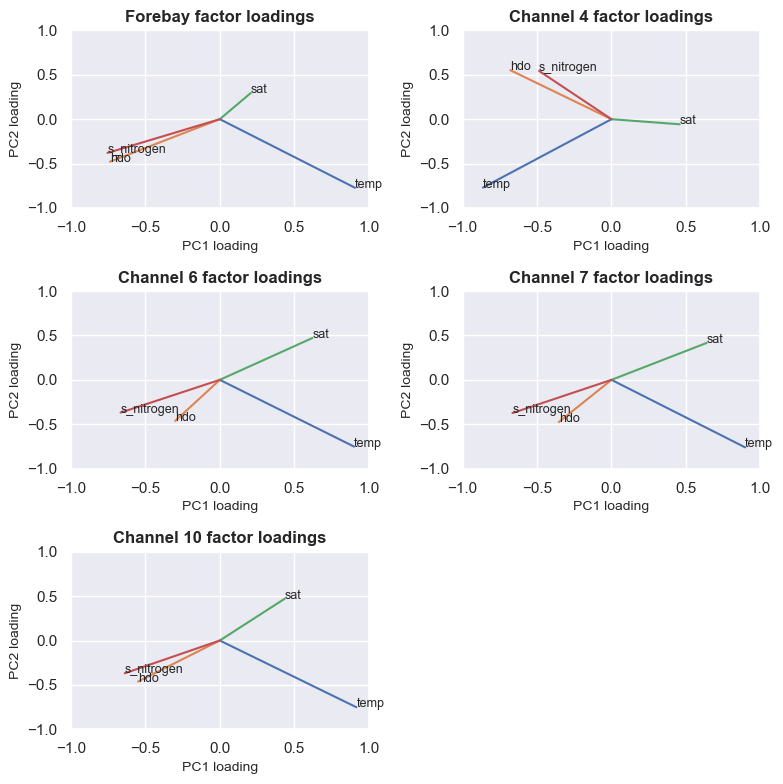

In [15]:
sns.set()
#Initialize figure with 6 subplots for forebay and controls
figs, axs = plt.subplots(nrows=3, ncols=2, figsize=[8, 8])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup factor loading subplot for channel 4
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 4 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 4
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c4PCA_FactorMatrix[i, 0]], [0, c4PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c4PCA_FactorMatrix[i, 0], c4PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup factor loading subplot for channel 6
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 6 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 6
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c6PCA_FactorMatrix[i, 0]], [0, c6PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c6PCA_FactorMatrix[i, 0], c6PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup factor loading subplot for channel 7
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 7 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 7
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c7PCA_FactorMatrix[i, 0]], [0, c7PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c7PCA_FactorMatrix[i, 0], c7PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup factor loading subplot for channel 10
axs[2, 0].set_xlim([-1, 1])
axs[2, 0].set_ylim([-1, 1])
axs[2, 0].set_xlabel('PC1 loading', fontsize=10)
axs[2, 0].set_ylabel('PC2 loading', fontsize=10)
axs[2, 0].set_title('Channel 10 factor loadings', fontweight='bold')
axs[2, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[2, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 10
for i, txt in enumerate(varlist):
    axs[2, 0].plot([0, c10PCA_FactorMatrix[i, 0]], [0, c6PCA_FactorMatrix[i, 1]], '-')
    axs[2, 0].text(c10PCA_FactorMatrix[i, 0], c6PCA_FactorMatrix[i, 1], txt,fontsize=9)

figs.delaxes(axs[2, 1]) #Remove 6th unused subplot position

plt.tight_layout() #Cleanup subplots

<b>Figure 4.</b> Principle component loadings for forebay and control treatment channel discharge.

Overall, the factor loadings for most control channels are similar to forebay factor loadings, which is not unexpected because control channels contain untreated water.  Along PC1, oxygen and nitrate are inversely correlated with temperature. One possible explanation for this could be water height and flow in the forebay and treatments. If a limited amount of water was pumped to the forebay and channels, it could lead to a small pool of stagnant water with high temperatures with low oxygen concentrations while biological activity could reduce nitrate concentrations in the water. However, if more water was pumped to the forebay and channels, increasing water flow would introduce more nitrate from farm runoff and allow for increased flushing that may lead to increasing oxygen.

Along PC2, saturation and temperature are inversely correlated while nitrate and oxygen vary less. If the saturation measurement is a measure of turbidity, the inverse relationship between it and temperature could make sense. Increasing turbidity could lead to less sunlight penetrating the water column and decrease temperatures in each channel due to shading. However, since there are no units or other information on saturation, this is merely speculation.

Channel 4 deviates from these apparent trends, and more closely aligns with factor loadings for woodchip treatment channels (fig. 4). Channel 4 was sandwiched between two woodchip treatment channels (3 and 5) and the deviation from factor loadings for control channels could be due to water spillover from adjacent woodchip bioreactor channels.

#### *Generating factor loading figures for woodchip channels and discussion*

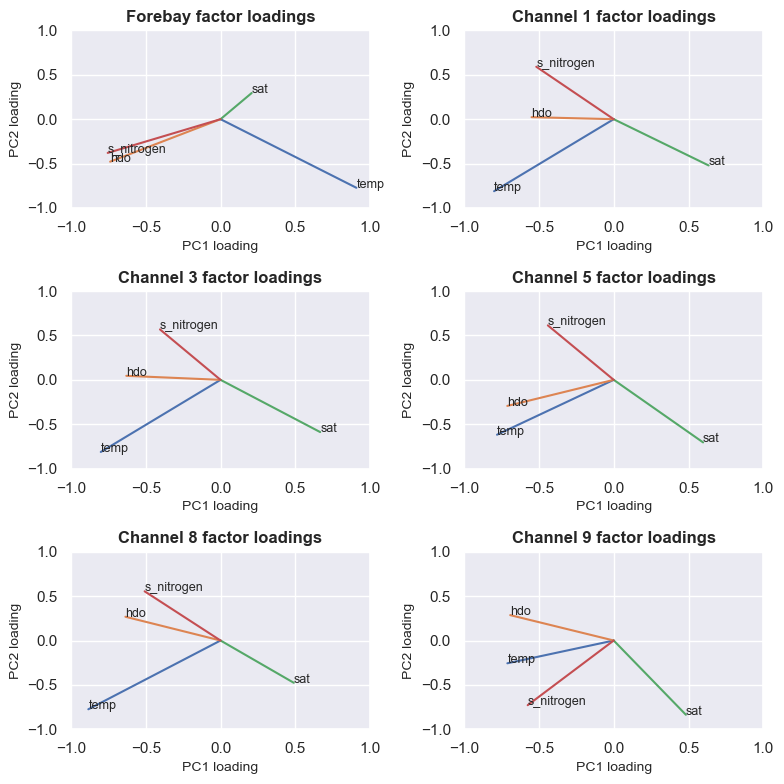

In [16]:
#Initialize figure with 4 subplots for forebay and wetland treatment
sns.set()
figs, axs = plt.subplots(nrows=3, ncols=2, figsize=[8, 8])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup factor loading subplot for channel 1
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 1 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 1
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c1PCA_FactorMatrix[i, 0]], [0, c1PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c1PCA_FactorMatrix[i, 0], c1PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup factor loading subplot for channel 3
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 3 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 3
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c3PCA_FactorMatrix[i, 0]], [0, c3PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c3PCA_FactorMatrix[i, 0], c3PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup factor loading subplot for channel 5
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 5 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 5
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c5PCA_FactorMatrix[i, 0]], [0, c5PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c5PCA_FactorMatrix[i, 0], c5PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup factor loading subplot for channel 8
axs[2, 0].set_xlim([-1, 1])
axs[2, 0].set_ylim([-1, 1])
axs[2, 0].set_xlabel('PC1 loading', fontsize=10)
axs[2, 0].set_ylabel('PC2 loading', fontsize=10)
axs[2, 0].set_title('Channel 8 factor loadings', fontweight='bold')
axs[2, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[2, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 8
for i, txt in enumerate(varlist):
    axs[2, 0].plot([0, c8PCA_FactorMatrix[i, 0]], [0, c8PCA_FactorMatrix[i, 1]], '-')
    axs[2, 0].text(c8PCA_FactorMatrix[i, 0], c8PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup factor loading subplot for channel 9
axs[2, 1].set_xlim([-1, 1])
axs[2, 1].set_ylim([-1, 1])
axs[2, 1].set_xlabel('PC1 loading', fontsize=10)
axs[2, 1].set_ylabel('PC2 loading', fontsize=10)
axs[2, 1].set_title('Channel 9 factor loadings', fontweight='bold')
axs[2, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[2, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 9
for i, txt in enumerate(varlist):
    axs[2, 1].plot([0, c9PCA_FactorMatrix[i, 0]], [0, c9PCA_FactorMatrix[i, 1]], '-')
    axs[2, 1].text(c9PCA_FactorMatrix[i, 0], c9PCA_FactorMatrix[i, 1], txt,fontsize=9)

plt.tight_layout() #Cleanup subplots

<b>Figure 5.</b> Principle component loadings for forebay and woodchip treatment channel discharge.

The factor loadings for all woodchip channelsare  alike but differ from the forebay. Along PC1, saturation is negatively correlated with temperature, nitrate, and oxygen. This is similar to PC2 factor loadings for the control treatments and forebay, but it is most likely the presence of woodchips altering water quality unlike in the control channels and forebay where those characteristics are for untreated water. In this case, the woodchips could shade water passing through, decreasing the temperature. Additionally, the woodchips should encourage the formation of an anoxic environment and reduce nitrate concentration due to microbial activity. Conversely, if saturation is a measure of turbidity or water clarity, the woodchips may leach tannins into the water or high amounts organic matter may be present due to microbial turnover, either of which would increase saturation. This could be an explanation for why nitrate, temperature, and dissolved oxygen are inversely correlated with saturation. 

For PC2, the nitrate concentration is inversely correlated with temperature and saturation for most woodchip treatment channels. One possible reason for the relationship between temperature and nitrate is microbial denitrification. Higher temperatures could facilitate microbial metabolism leading to enhanced nitrogen removal from the water. However, the row of saturation in this is unclear. Another area of uncertainty is in channel 9 where nitrogen and saturation are inversely correlated with dissolved oxygen while temperature does not vary as much along PC2.

#### *Generating factor loading figures for wetland channels and discussion*

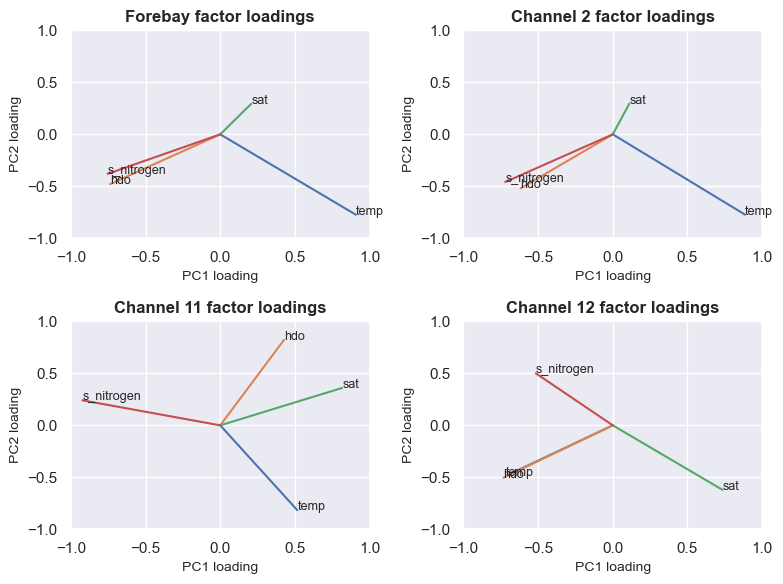

In [17]:
#Initialize figure with 4 subplots for wetland treatments and foebay
figs, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 6])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 2
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 2 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 2
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c2PCA_FactorMatrix[i, 0]], [0, c2PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c2PCA_FactorMatrix[i, 0], c2PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 11
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 11 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 11
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c11PCA_FactorMatrix[i, 0]], [0, c11PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c11PCA_FactorMatrix[i, 0], c11PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup forebay factor loading subplot for channel 12
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 12 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 12
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c12PCA_FactorMatrix[i, 0]], [0, c12PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c12PCA_FactorMatrix[i, 0], c12PCA_FactorMatrix[i, 1], txt, fontsize=9)

plt.tight_layout() #Cleanup subplots

<b>Figure 6.</b> Principle component loadings for forebay and wetland treatment channel discharge.

There are no overarching shared characteristics in wetland channels. This variability is not surprising since the unvegetated treatment channels and woodchip channels are homogenous environments where similarities are to be expected while the vegetated wetland treatments likely had factors contribution to more heterogeneity across treatments. Such factors include vegetation growth, coverage, and overall health in the treatment channels. Plant cover would impact variables like temperature through shading while plant density would impact nitrate uptake rates and oxygen production. Furthermore, again assuming saturation is a measure of turbidity or water clarity, root extent and plant density could impact this by roots securing sediment and dense vegetation slowing waterflow thereby diminishing turbidity while sparse roots and vegetation may encourage the opposite. For example, the factor loadings for channel 2 closely resemble those of the forebay, this may indicate that channel 2 was more sparsely vegetated than the other two channels and therefore had water parameters closer to that of the forebay or control channels.

#### *Percentage of variance in the data accounted for by PC1 and PC2 across treatments*

In [18]:
#Accessing information stored in PCA_PC1pvar and PCA_PC2pvar variables
#For forebay
print('Forebay:   PC1 = ' + str(np.round(fbPCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(fbPCA_PC2pvar, 2)))
#For control channels
print('\nControl (channel 4):   PC1 = ' + str(np.round(c4PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c4PCA_PC2pvar, 2)))
print('Control (channel 6):   PC1 = ' + str(np.round(c6PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c6PCA_PC2pvar, 2)))
print('Control (channel 7):   PC1 = ' + str(np.round(c7PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c7PCA_PC2pvar, 2)))
print('Control (channel 10):   PC1 = ' + str(np.round(c10PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c10PCA_PC2pvar, 2)))
#For woodchips channels
print('\nWoodchip (channel 1):   PC1 = ' + str(np.round(c1PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c1PCA_PC2pvar, 2)))
print('Woodchip (channel 3):   PC1 = ' + str(np.round(c3PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c3PCA_PC2pvar, 2)))
print('Woodchip (channel 5):   PC1 = ' + str(np.round(c5PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c5PCA_PC2pvar, 2)))
print('Woodchip (channel 8):   PC1 = ' + str(np.round(c8PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c8PCA_PC2pvar, 2)))
print('Woodchip (channel 9):   PC1 = ' + str(np.round(c9PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c9PCA_PC2pvar, 2)))
#For wetland channels
print('\nWetland (channel 2):   PC1 = ' + str(np.round(c2PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c2PCA_PC2pvar, 2)))
print('Wetland (channel 11):   PC1 = ' + str(np.round(c11PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c11PCA_PC2pvar, 2)))
print('Wetland(channel 12):   PC1 = ' + str(np.round(c12PCA_PC1pvar, 2)) + '   PC2 = ' + str(np.round(c12PCA_PC2pvar, 2)))

Forebay:   PC1 = 49.49   PC2 = 26.46

Control (channel 4):   PC1 = 41.29   PC2 = 29.93
Control (channel 6):   PC1 = 43.31   PC2 = 28.44
Control (channel 7):   PC1 = 44.57   PC2 = 27.98
Control (channel 10):   PC1 = 43.51   PC2 = 27.72

Woodchip (channel 1):   PC1 = 40.25   PC2 = 32.02
Woodchip (channel 3):   PC1 = 41.09   PC2 = 33.31
Woodchip (channel 5):   PC1 = 41.59   PC2 = 33.57
Woodchip (channel 8):   PC1 = 42.02   PC2 = 30.16
Woodchip (channel 9):   PC1 = 38.65   PC2 = 34.48

Wetland (channel 2):   PC1 = 42.4   PC2 = 29.13
Wetland (channel 11):   PC1 = 49.16   PC2 = 38.27
Wetland(channel 12):   PC1 = 46.29   PC2 = 28.16


The variability in data that PC1 accounts for across the forebay and channels ranges from 38.65 – 49.49% while PC2 accounts for 26.64 – 34.48%. The percent variance for PC1 and PC2 from the forebay account for the highest and lowest percent variabilities respectively. The inverse is true for channel 9 where percentage of variability accounted by PC1 is the lowest and PC2 is the highest amongst the forebay and channels. 

Overall, variance is similar amongst treatment replicates aside from some potential outliers. Woodchip treatments all have similar percentages for PC1 (40.25 – 42.02%) and PC2 (30.13 – 33.57%) aside from channel 9 which has slightly a lower percentage for PC1 (38.65%) and slightly higher for PC2 (34.48%). This may be reflective of channel 9 having a slightly different factor loading distribution compared to other woodchip treatments (fig. 5).

This also appears to occur with control channels where PC1 accounts for 43.31 – 44.57% and PC2 accounts for 27.72 – 28.44% of overall variance in the data aside from channel 4 where PC1 accounts for 41.29% and PC2 for 29.93%. While these differences in percentages are slight, they may be indicative of the slight differences in factor loadings between channel 4 (fig. 4) and channel 9 (fig. 5) compared to the rest of the replicates in their respective treatments. This is corroborated by the variances for the wetland channels which had the most variable factor loadings (fig. 6) and the highest variability in percentage of variance in the data accounted for by PC1 (42.40 – 49.16%) and PC2 (28.16 – 38.27%).

### Plots and ANOVA for temperature

#### *Plotting variability in temperatature data across treatment and between seasons*

The code below constructs violin plots with some boxplot elements (first and third quartiles, median, and average) to visual the data structure and distribution of temperature across treatment and with season.

Text(6.5, 26.5, 'Summer')

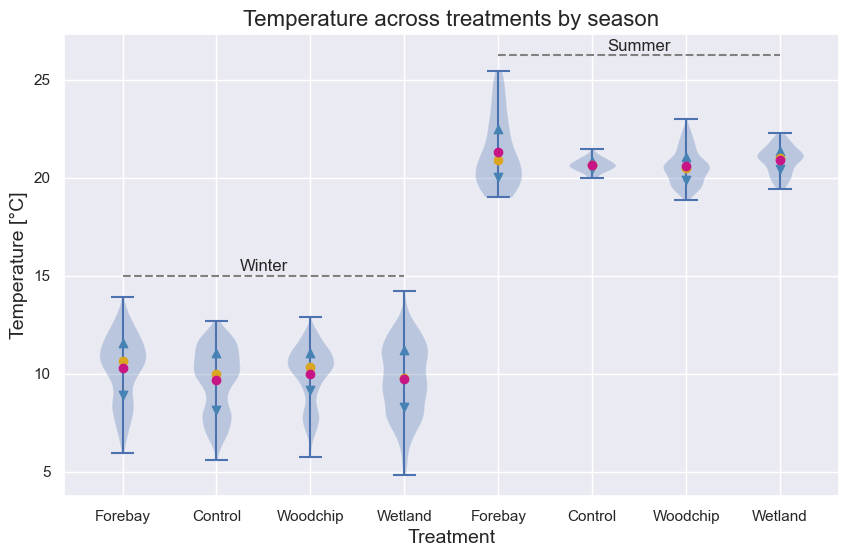

In [19]:
#Populating an array with temperature data for treatments across seasons
seasonaltempdata = [forebay_wintertemps['temp'], control_wintertemps['temp'], woodchip_wintertemps['temp'], wetland_wintertemps['temp'], forebay_summertemps['temp'], control_summertemps['temp'], woodchip_summertemps['temp'], wetland_summertemps['temp']]

#Creating a list for labels
seasonaltemplabels = ['Forebay', 'Control', 'Woodchip', 'Wetland', 'Forebay', 'Control', 'Woodchip', 'Wetland']

#Initialize violin plot
sns.set()
plt.figure(figsize=(10, 6))
vp = plt.violinplot(seasonaltempdata)

#Add axes labels and title
plt.xticks(range(1, len(seasonaltemplabels) + 1), seasonaltemplabels)
plt.title('Temperature across treatments by season', fontsize=16)
plt.xlabel('Treatment', fontsize=14)
plt.ylabel('Temperature [°C]', fontsize=14)

#Add markers for median, average, first quartile, and third quartile across treatments
for i in range(len(seasonaltempdata)):
    Tquartiles = np.percentile(seasonaltempdata[i], [25, 50, 75])
    plt.scatter(i + 1, Tquartiles[0], color='steelblue', marker='v', zorder=5)
    plt.scatter(i + 1, Tquartiles[2], color='steelblue', marker='^', zorder=5)
    plt.scatter(i + 1, Tquartiles[1], color='goldenrod', marker='o', zorder=5)
    plt.scatter(i + 1, np.average(seasonaltempdata[i].values), color='mediumvioletred', marker='o', zorder=5)


#Generate line and label to indicate winter conditions
plt.plot([1, 4], [15, 15], color='gray', lw=1.5, linestyle='--')
plt.text(2.5, 15.25, 'Winter', ha='center', fontsize=12)

#Generate line and label to indicate summer conditons
plt.plot([5, 8], [26.25,26.25], color='gray', lw=1.5, linestyle='--')
plt.text(6.5, 26.5, 'Summer', ha='center', fontsize=12)

<b>Figure 7.</b> Violin plots for temperature across treatment in winter months (January & December) versus summer (August) from selected timeframes. First and third quartiles are indicated by upward or downward arrows. Medians are plotted as gold circles and averages as magenta circles.

Winter temperatures are cooler than summer temperatures and there is no overlap in the data between the two seasons. Across both seasons, the medians and averages across the forebay and treatment are closely aligned, indicating that the bulk of temperatures is relatively consistent across treatments for a given season.

In the winter, overall distribution of data is quite similar across the forebay and channels where data is clustered around 10.1 – 11°C (fig. 7). However, the wetland channel has a more normal distribution with what appears to be a slight multimodal distribution with three humps of data. This could be due to the apparent high variability of water parameters that was observed in the PCA (fig. 6) in comparison to other treatments and the forebay (fig. 4 & 5).

While the averages and medians are similar across the forebay and treatment channels, the data structure for the forebay is tailed towards higher temperatures when compared to the more normally distributed treatment channel temperature data. This may be due to the forebay pond have a different structure than the channels; the forebay was a deeper well that fed into shallow, linear channels which may have somehow influenced temperature dynamics. Line placement leading to the Hyrda could also have been a factor. If the line leading to the Hydra was situated in shallow water along the edges of the forebay, it may have been prone to picking up higher temperatures from stagnant warmed water. However, if more timeframes were compared, this structure may change as what is plotted covers a smaller amount of data and only one timeframe identified in Krone et al. 2022.

#### *ANOVA comparing temperature across treatments in winter and summer*

The code below is for running Welch’s ANOVA to compare temperature across treatments in winter and summer. Welch’s ANOVA was selected due to uneven spread of data across treatments (fig. 7) to account for differences in variance across treatment.

In [20]:
#ANOVA for winter temeperatures across treatment
pg.welch_anova(data=dfsub_wintertempall, dv='temp', between='treatment')

,Source,ddof1,ddof2,F,p-unc,np2
0,treatment,3,1189.891303,17.257504,5.670321e-11,0.014383


In [21]:
#F-values for the above Welch ANOVA
stats.f.ppf(0.95, 3, 1189.981)

2.6123811324599275

In [22]:
#Pairwise Tukey post-hoc for temperature in winter treatment
pg.pairwise_gameshowell(data=dfsub_wintertempall, dv='temp', between='treatment')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Untreated,9.697343,10.313120,-0.615777,0.108264,-5.687754,544.508350,1.258846e-07,-0.364906
1,Control,Wetland,9.697343,9.710342,-0.012999,0.083358,-0.155941,1685.839580,9.986497e-01,-0.007396
2,Control,Woodchip,9.697343,10.011440,-0.314097,0.064252,-4.888539,1890.636866,6.560845e-06,-0.203178
3,Untreated,Wetland,10.313120,9.710342,0.602778,0.114117,5.282119,639.916419,1.046996e-06,0.333848
4,Untreated,Woodchip,10.313120,10.011440,0.301680,0.101007,2.986728,424.173647,1.573488e-02,0.201241
5,Wetland,Woodchip,9.710342,10.011440,-0.301098,0.073688,-4.086134,1357.064098,2.709344e-04,-0.188558


In [23]:
#ANOVA for summer temeperatures across treatment
pg.welch_anova(data=dfsub_summertempall, dv='temp', between='treatment')

,Source,ddof1,ddof2,F,p-unc,np2
0,treatment,3,237.156556,10.588217,0.000001,0.068492


In [24]:
#F-values for the above Welch ANOVA
stats.f.ppf(0.95, 3, 237.157)

2.642664320370205

In [25]:
#Pairwise Tukey post-hoc for temperature in summer treatments
pg.pairwise_gameshowell(data=dfsub_summertempall, dv='temp', between='treatment')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Untreated,20.656463,21.313633,-0.657170,0.163264,-4.025198,128.325301,0.000555,-0.506530
1,Control,Wetland,20.656463,20.922815,-0.266352,0.083362,-3.195118,107.168268,0.009787,-0.512254
2,Control,Woodchip,20.656463,20.574478,0.081985,0.053739,1.525617,461.763558,0.422944,0.102312
3,Untreated,Wetland,21.313633,20.922815,0.390819,0.177727,2.198987,167.170719,0.127731,0.273011
4,Untreated,Woodchip,21.313633,20.574478,0.739155,0.165908,4.455219,136.864585,0.000101,0.649291
5,Wetland,Woodchip,20.922815,20.574478,0.348337,0.088428,3.939229,135.978736,0.000744,0.407143


The Welch’s ANOVA and post-hoc pairwise test indicate concerningly high levels of significance between nearly all treatment channels and the forebay for both winter and summer temperature values. Ideally, the control treatments should not have a statistically significant variability when compared to the forebay, yet nearly all do. This is highly likely due to the lack of decorrelation via averaging increase independence within treatments and channels. Solutions are discussed in the future direction section. 

However, expected results after data undergoes decorrelation can be surmised from data distribution (fig. 7). Given the similar range of values for temperature across channels and the forebay in winter, it is unlikely there will be a statistically significant difference between any channels or the forebay. The same is likely true for summer temperatures, but because of the wide data distribution for the forebay it may be significantly different than any of the treatment channels that span smaller ranges of temperature. 

### Plots and ANOVA for nitrate concentrations

#### *Plotting variability in nitrate data across treatment and between seasons*

The code below constructs violin plots with some boxplot elements (first and third quartiles, median, and average) to visual the data structure and distribution of nitrate concentration across treatment and with season and any reduction or increase in treatment channels compared to the forebay.

Text(6.5, 63.25, 'Summer')

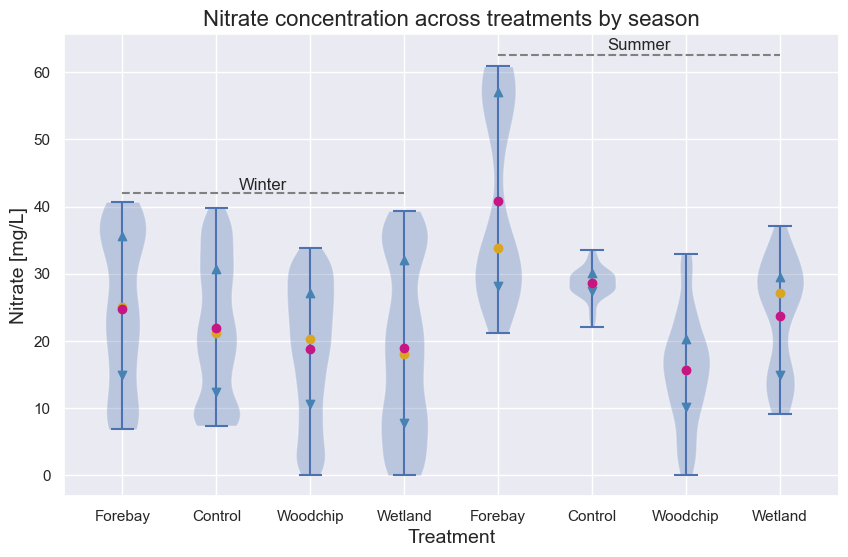

In [26]:
#Polating an array with nitrate data for treatments across seasons
seasonalNdata = [forebay_winterN['s_nitrogen'], control_winterN['s_nitrogen'], woodchip_winterN['s_nitrogen'], wetland_winterN['s_nitrogen'], forebay_summerN['s_nitrogen'], control_summerN['s_nitrogen'], woodchip_summerN['s_nitrogen'], wetland_summerN['s_nitrogen']]

#Creating a list for labels
seasonalNlabels = ['Forebay', 'Control', 'Woodchip', 'Wetland', 'Forebay', 'Control', 'Woodchip', 'Wetland']

#Initialize violin plot
sns.set()
plt.figure(figsize=(10, 6))
vp = plt.violinplot(seasonalNdata)

#Add axes labels and title
plt.xticks(range(1, len(seasonalNlabels) + 1), seasonalNlabels)
plt.title('Nitrate concentration across treatments by season', fontsize=16)
plt.xlabel('Treatment', fontsize=14)
plt.ylabel('Nitrate [mg/L]', fontsize=14)

#Add markers for median, average, first quartile, and third quartile across treatments
for i in range(len(seasonalNdata)):
    Nquartiles = np.percentile(seasonalNdata[i], [25, 50, 75])
    plt.scatter(i + 1, Nquartiles[0], color='steelblue', marker='v', zorder=5)
    plt.scatter(i + 1, Nquartiles[2], color='steelblue', marker='^', zorder=5)
    plt.scatter(i + 1, Nquartiles[1], color='goldenrod', marker='o', zorder=5)
    plt.scatter(i + 1, np.average(seasonalNdata[i].values), color='mediumvioletred', marker='o', zorder=5)

#Generate line and label to indicate winter conditions
plt.plot([1, 4], [42,42], color='gray', lw=1.5, linestyle='--')
plt.text(2.5, 42.5, 'Winter', ha='center', fontsize=12)

#Generate line and label to indicate summer conditons
plt.plot([5, 8], [62.5,62.5], color='gray', lw=1.5, linestyle='--')
plt.text(6.5, 63.25, 'Summer', ha='center', fontsize=12)

<b>Figure 8.</b> Violin plots for nitrate concentrations across treatment in winter months (January & December) versus summer (August) from selected timeframes. First and third quartiles are indicated by upward or downward arrows. Medians are plotted as gold circles and averages as magenta circles.

#### *Nitrate violin plot discussion*

Winter nitrate concentrations are lower than those in the forebay and control channel discharge in the summer, but similar to the summer woodchip and wetland channel discharge. These lower nitrate levels are probably due to these timeframes falling outside the agricultural growing season when farming runoff flows through CSTW.

Despite the lower overall nitrate levels, there appears to be a reduction in nitrate concentration from the forebay to the woodchip and treatment channels because the median and averages (around 19 – 20 mg/L; fig. 8) for those treatment channels fall below that of the forebay (approximately 25 mg/L).  However, the wetland treatment data distribution does cover a wider range for concentration values and the maximum value for that treatment is like that of control channels and the forebay. 

The summer data reveals a much stronger potential reduction in overall nitrate concentrations, especially the woodchip treatment discharge (median and average are about 15mg/L) compared to the forebay (approximate median at 34 mg/L and average just above 40 mg/L). There are reductions for the control and wetland channels as well when compared to the forebay data distribution. The median and average values across all channels fall below the median and average for the forebay. However, the average for the forebay may not be as reflective of concentrations since the data follows a bimodal distribution. Nonetheless, a clear reduction in nitrate concentrations is occurring in treatment channels that warrants statistical analysis. 

#### *ANOVA comparing nitrate concentrations across treatments in winter and summer*

The code below is for running Welch’s ANOVA to compare nitrate concentration across treatments in winter and summer. Welch’s ANOVA was selected due to uneven spread of data across treatments (fig. 8) to account for differences in variance across treatment.

In [27]:
#ANOVA for winter nitrate concentration across treatment
pg.welch_anova(data=dfsub_winterNall, dv='s_nitrogen', between='treatment')

,Source,ddof1,ddof2,F,p-unc,np2
0,treatment,3,1185.653549,41.270269,2.282361e-25,0.03229


In [28]:
#F-value for the above Welch ANOVA
stats.f.ppf(0.95, 3, 1185.654)

2.6124084482868115

In [29]:
#Pairwise Tukey post-hoc for nitrate concentrations in winter treatment
pg.pairwise_gameshowell(data=dfsub_winterNall, dv='s_nitrogen', between='treatment')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Untreated,21.875689,24.811106,-2.935416,0.700013,-4.193375,501.884041,1.899837e-04,-0.283597
1,Control,Wetland,21.875689,18.930333,2.945357,0.549466,5.360395,1494.334886,5.745555e-07,0.260937
2,Control,Woodchip,21.875689,18.777696,3.097993,0.401144,7.722904,2097.427514,0.000000e+00,0.311492
3,Untreated,Wetland,24.811106,18.930333,5.880773,0.768755,7.649741,672.612857,3.845813e-13,0.478442
4,Untreated,Woodchip,24.811106,18.777696,6.033410,0.670810,8.994212,430.268106,1.567635e-13,0.595544
5,Wetland,Woodchip,18.930333,18.777696,0.152636,0.511744,0.298267,1289.768180,9.907763e-01,0.014014


In [30]:
#ANOVA for summer nitrate concentration across treatment
pg.welch_anova(data=dfsub_summerNall, dv='s_nitrogen', between='treatment')

,Source,ddof1,ddof2,F,p-unc,np2
0,treatment,3,229.774465,308.069376,3.251481e-80,0.534175


In [31]:
#F-value for the above Welch ANOVA
stats.f.ppf(0.95, 3, 229.774)

2.643888427996136

In [32]:
#Pairwise Tukey post-hoc for nitrate concentrations in summer treatment
pg.pairwise_gameshowell(data=dfsub_summerNall, dv='s_nitrogen', between='treatment')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Untreated,28.601143,40.802508,-12.201366,1.274887,-9.570545,126.378128,1.998401e-15,-1.203467
1,Control,Wetland,28.601143,23.720635,4.880508,0.936963,5.208861,89.505093,7.121480e-06,0.862651
2,Control,Woodchip,28.601143,15.672020,12.929123,0.462590,27.949398,506.019576,1.932898e-13,1.768104
3,Untreated,Wetland,40.802508,23.720635,17.081874,1.550879,11.014316,196.310597,0.000000e+00,1.437686
4,Untreated,Woodchip,40.802508,15.672020,25.130489,1.319590,19.044168,144.741835,0.000000e+00,2.583303
5,Wetland,Woodchip,23.720635,15.672020,8.048615,0.996935,8.073363,114.111982,4.626521e-12,0.986759


ANOVA results after decorrelation occurs can be hypothesized from the data distribution (fig. 8) and possibly some Games-Howell post-hoc pairwise p-values. For the winter months, there may be  significant difference between the following treatment pairs: forebay-wetland, forebay-woodchip, and control-woodchip. This is based on the apparent reduction in values from fig. 8 and extremely low corresponding p-values in the winter ANOVA analyses (where “Untreated signifies water from the forebay).

When ANOVA is performed on decorrelated data for the summer timeframe, there are likely to be even more significant differences between treatment. From observing how the data is distributed and looking for particularly low p-values in the ANOVA the following pairs are more likely to be significantly different:
* Untreated-woodchip
* Untreated-wetland
* Control-untreated

These particularly for untreated-wetland and untreated-woodchip comparison based on p-values that are functionally zero in the above flawed summer ANOVA and from the lower range of nitrate distributions for woodchip and wetland treatments compared to the forebay in the summer (fig. 8).

### Future direction

Autocorrelation will be utilized to identify timescales where a timeseries is decorrelated with itself for a given parameter (e.g., nitrate concentration or time). To detrend data, a rolling average will be applied to each timeseries using the timescale identified using an autocorrelation function. This will facilitate a more robust statistical analysis between treatments using Welch’s ANOVA. This will be done for nitrate and temperature for the timeseries used in the above analyses and eventually expanded to other portions of the dataset with good data coverage and quality.

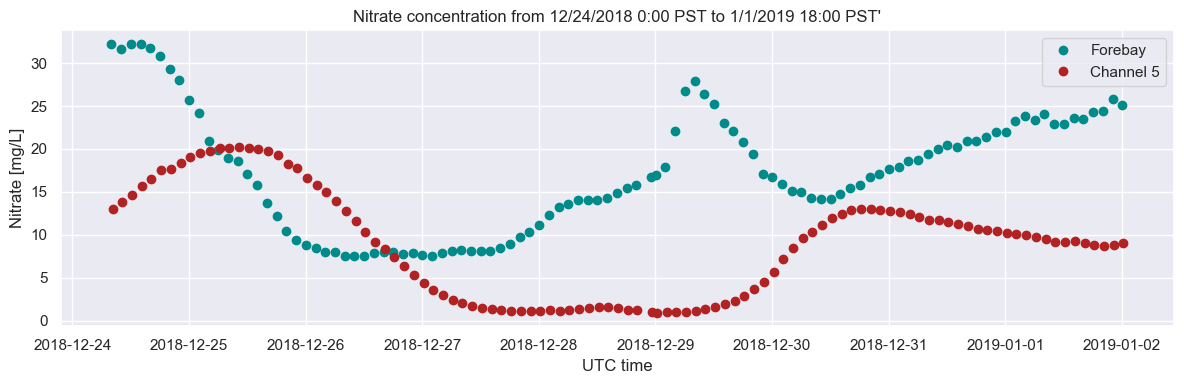

In [33]:
#Initializing figure to illustrate raw data structure in the 's_nitrate' column
plt.figure(figsize=[12, 4])
plt.plot(dffb_sub1['utc_time'], dffb_sub1['s_nitrogen'], 'o', color='darkcyan', label='Forebay')
plt.plot(dfc5_sub1wc['utc_time'], dfc5_sub1wc['s_nitrogen'], 'o', color='firebrick', label='Channel 5')
plt.xlabel('UTC time')
plt.ylabel("Nitrate [mg/L]")
plt.title("Nitrate concentration from 12/24/2018 0:00 PST to 1/1/2019 18:00 PST'")
plt.legend(loc=1)
plt.tight_layout()

<b>Figure 9.</b> Nitrate concentrations in the forebay (teal) versus channel 5 (red; woodchip treatment) across UTC time. Note the peaks and troughs in the forebay reflected in channel 5 as reduced nitrate concentrations after a time lag. 

To calculate the residence time of water flowing from the forebay through a given channel, cross-correlation functions will be used. The time lag where peaks in concretion from forebay correlate with peaks in each channel’s discharge will represent overall time a parcel of water spent flowing from the forebay through the channel (residence time) (fig. 9). Changes in nitrate concentration can be calculated by adjusting for this time lag and subtracting nitrate concentrations in the channel discharge from those in the forebay at the associated adjusted time. 

Autocorrelation and cross-correlation calculations and subsequent analyses will first be applied to the timeframes identified in Krone et al. 2022 but will then be expanded to other timeframes with good data coverage and quality with a focus on nitrate and temperature. 

### References

* Ballut-Dajud, G. A., L. C. Sandoval Herazo, G. Fernández-Lambert, J. L. Marín-Muñiz, M. C. López Méndez, and E. A. Betanzo-Torres. 2022. Factors Affecting Wetland Loss: A Review. Land 11: 434. doi:10.3390/land11030434
* Central Coast Wetlands Group. 2016. PG&E Constructed Treatment Wetland – Summary.
* Conlen, A., E. Eichorn, S. Greenway, T. Hutton, N. Inglis, M. Morris, M. Robinson, and R. Burton. 2017. Characterization of physical dimensions and nutrient reduction in an experimental treatment wetland.
* Fluet-Chouinard, E., B. D. Stocker, Z. Zhang, and others. 2023. Extensive global wetland loss over the past three centuries. Nature 614: 281–286. doi:10.1038/s41586-022-05572-6
* Hicks, K., R. Jeppesen, J. Haskins, and K. Wasson. 2019. Long-term trend and spatial patterns of water quality in estuarine wetlands of central California.
* Howarth, R., F. Chan, D. J. Conley, J. Garnier, S. C. Doney, R. Marino, and G. Billen. 2011. Coupled biogeochemical cycles: eutrophication and hypoxia in temperate estuaries and coastal marine ecosystems. Frontiers in Ecology and the Environment 9: 18–26. doi:10.1890/100008
* Hughes, B., J. Haskins, and K. Wasson. 2010. Assessment of the effects of nutrient loading in estuarine wetlands of the Elkhorn Slough watershed: a regional eutrophication report card.
* Krone, P., R. Clark, J. Adelaars, and others. 2022. Sizing an open-channel woodchip bioreactor to treat nitrate from agricultural tile drainage and achieve water quality targets. Water Supply 22: 2465–2477. doi:10.2166/ws.2022.007
* McCormick, P. V., S. Newman, and L. W. Vilchek. 2009. Landscape responses to wetland eutrophication: loss of slough habitat in the Florida Everglades, USA. Hydrobiologia 621: 105–114. doi:10.1007/s10750-008-9635-2
* The Habitat Restoration Group. 1996. Moro Cojo Slough Management and Enhancement Plan: Final Report.
* Woolfolk, A. 2020. Moro Cojo: A Historical Perspective. 3. 3.

